Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    06s66  006   4.909142e+03   3.124237e+04 
    24s31  019   4.432403e+03   5.574629e+04 
 01m12s17  055   4.181140e+03   1.469378e+03 
 03m23s87  155   4.084117e+03   1.259656e+04 
 04m27s19  202   4.070689e+03   2.280359e+03 
Runtime:  04m27s19
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    04s01  003   6.106075e+03   6.994576e+05 
    15s89  012   5.830752e+03   1.310274e+04 
    46s91  036   5.735662e+03   4.504753e+03 
 02m04s78  102   5.619329e+03   1.507778e+03 
 04m02s09  202   5.604333e+03   1.091247e+02 
Runtime:  04m02s09
Optimization status: Maximum number of f evaluations reached


Hybrid Model (Full + SGPR)
  RMSE: 0.4548
  MAE:  0.3535
  R²:   0.7928

Hybrid Model (Top-5 + SGPR)
  RMSE: 0.6353
  MAE:  0.4809
  R²:   0.5956


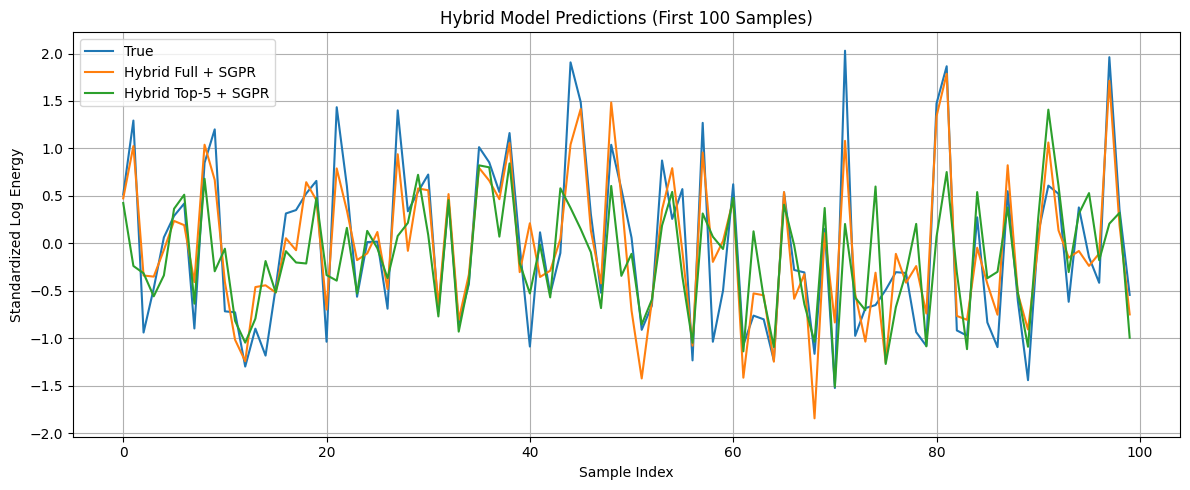

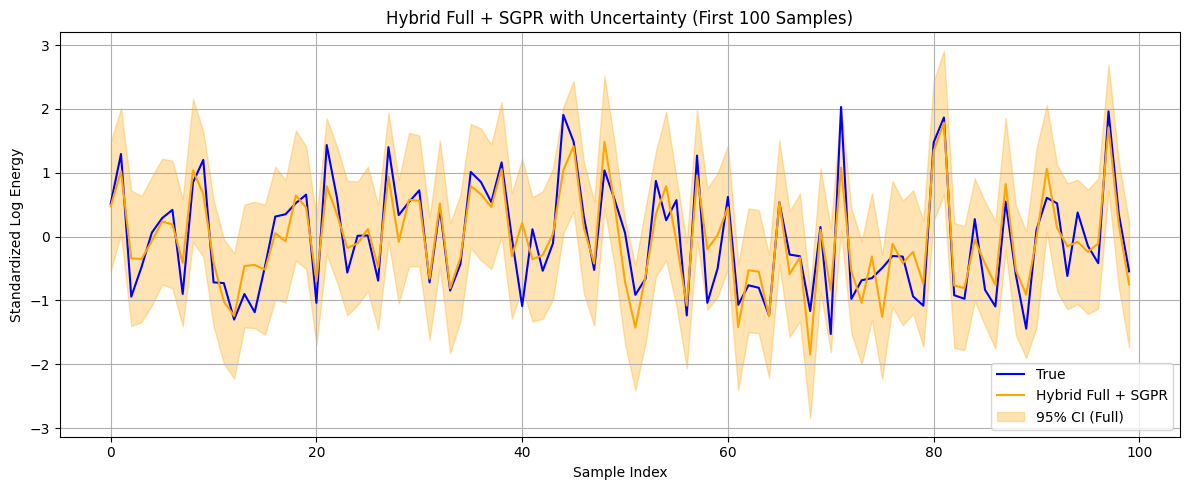

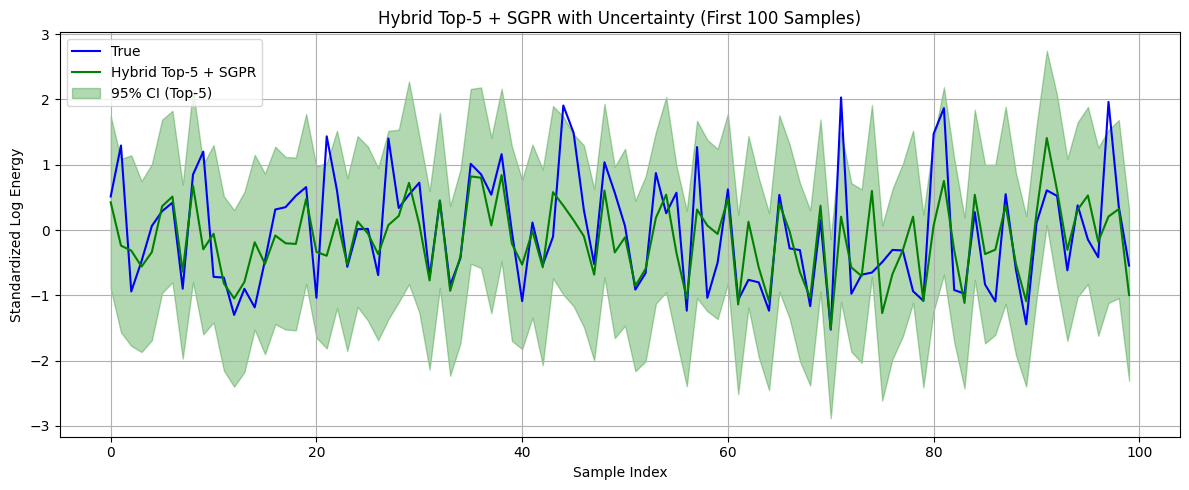

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import GPy
import matplotlib.pyplot as plt

# -------------------- Load and Prepare Data --------------------
df = pd.read_csv("/Users/zhongyucheng/Desktop/Spring2025/ACMS60890/final_project/Python codes/UPDATED_CODES/updated_hybrid/energydata_cleaned.csv")
target = 'Appliances_log_smooth'
features_full = [col for col in df.columns if col not in ['date', target]]
features_top5 = ['T2', 'T1', 'T3', 'T8', 'T4']

X_full = df[features_full].values
X_top5 = df[features_top5].values
y = df[target].values

# Train/test split
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
X_train_top5, X_test_top5 = train_test_split(X_top5, test_size=0.2, random_state=42)

# -------------------- Train White-Box Models --------------------
wb_full = LinearRegression().fit(X_train_full, y_train)
wb_top5 = LinearRegression().fit(X_train_top5, y_train)

# Predictions and residuals
y_pred_full = wb_full.predict(X_test_full)
y_pred_top5 = wb_top5.predict(X_test_top5)
resid_full_train = y_train - wb_full.predict(X_train_full)
resid_top5_train = y_train - wb_top5.predict(X_train_top5)

# -------------------- SGPR Training Function --------------------
def train_sgpr(X, residuals, num_inducing=75, max_iters=200):
    kernel = GPy.kern.RBF(input_dim=X.shape[1])
    Z = X[:num_inducing].copy()  # Inducing points
    sgpr = GPy.models.SparseGPRegression(X, residuals.reshape(-1, 1), kernel, Z=Z)
    sgpr.optimize(messages=True, max_iters=max_iters)
    return sgpr

# -------------------- Train SGPR Models --------------------
sgpr_full = train_sgpr(X_train_full[::3], resid_full_train[::3])
sgpr_top5 = train_sgpr(X_train_top5[::3], resid_top5_train[::3])

# -------------------- Hybrid Predictions --------------------
resid_pred_full, _ = sgpr_full.predict(X_test_full)
resid_pred_top5, _ = sgpr_top5.predict(X_test_top5)

y_pred_hybrid_full = y_pred_full + resid_pred_full.ravel()
y_pred_hybrid_top5 = y_pred_top5 + resid_pred_top5.ravel()

# -------------------- Evaluation --------------------
def evaluate(y_true, y_pred, label):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{label}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    return {"RMSE": rmse, "MAE": mae, "R²": r2}

results_hybrid_full = evaluate(y_test, y_pred_hybrid_full, "Hybrid Model (Full + SGPR)")
results_hybrid_top5 = evaluate(y_test, y_pred_hybrid_top5, "Hybrid Model (Top-5 + SGPR)")

# -------------------- Visualization --------------------
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100], label='True')
plt.plot(y_pred_hybrid_full[:100], label='Hybrid Full + SGPR')
plt.plot(y_pred_hybrid_top5[:100], label='Hybrid Top-5 + SGPR')
plt.legend()
plt.title("Hybrid Model Predictions (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Standardized Log Energy")
plt.grid()
plt.tight_layout()
plt.savefig("comparison_figure/comparisons.pdf", bbox_inches='tight')
plt.show()

# -------------------- Visualization Updated: Plotting Predictions with 95% Confidence Intervals --------------------
# --- Full-feature SGPR: Predict residuals and uncertainty ---
mu_full, var_full = sgpr_full.predict(X_test_full)
lower_full = mu_full.ravel() - 1.96 * np.sqrt(var_full.ravel())
upper_full = mu_full.ravel() + 1.96 * np.sqrt(var_full.ravel())
y_lower_full = y_pred_full + lower_full
y_upper_full = y_pred_full + upper_full

# --- Top-5-feature SGPR: Predict residuals and uncertainty ---
mu_top5, var_top5 = sgpr_top5.predict(X_test_top5)
lower_top5 = mu_top5.ravel() - 1.96 * np.sqrt(var_top5.ravel())
upper_top5 = mu_top5.ravel() + 1.96 * np.sqrt(var_top5.ravel())
y_lower_top5 = y_pred_top5 + lower_top5
y_upper_top5 = y_pred_top5 + upper_top5

# --- Plot Full-feature Hybrid with Uncertainty ---
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100], label='True', color='blue')
plt.plot(y_pred_hybrid_full[:100], label='Hybrid Full + SGPR', color='orange')
plt.fill_between(
    range(100),
    y_lower_full[:100],
    y_upper_full[:100],
    color='orange',
    alpha=0.3,
    label='95% CI (Full)'
)
plt.title("Hybrid Full + SGPR with Uncertainty (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Standardized Log Energy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("comparison_figure/comparison2.pdf", bbox_inches='tight')
plt.show()

# --- Plot Top-5-feature Hybrid with Uncertainty ---
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100], label='True', color='blue')
plt.plot(y_pred_hybrid_top5[:100], label='Hybrid Top-5 + SGPR', color='green')
plt.fill_between(
    range(100),
    y_lower_top5[:100],
    y_upper_top5[:100],
    color='green',
    alpha=0.3,
    label='95% CI (Top-5)'
)
plt.title("Hybrid Top-5 + SGPR with Uncertainty (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Standardized Log Energy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("comparison_figure/comparison3.pdf", bbox_inches='tight')
plt.show()